# Predicting the “Fraud in auto insurance claims” & Pattern extraction

# Problem statement


A major general insurance company has a business problem with significant number of claims 
being reported are fraudulent in nature and it is leading to leakages. So, the Insurer decided to 
predict the fraudulent ones before even processing the claims to allocate costs appropriately, to 
keep the thorough investigation process in place and to design proper action plan for the claims etc.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

# Loading Datasets

In [2]:
train_claim=pd.read_csv(r'C:\Users\manoj\Downloads\Capstone_Project_export\capstone-files\TrainData\train_claim_new1.csv',na_values=['?','Unknown/Invalid','nan','MISSEDDATA','MISSINGVALUE','-5'])
train_demographics=pd.read_csv(r'C:\Users\manoj\Downloads\Capstone_Project_export\capstone-files\TrainData\Train_Demographics.csv',na_values=['?','Unknown/Invalid','nan','MISSEDDATA','MISSINGVALUE'])
train_policy=pd.read_csv(r'C:\Users\manoj\Downloads\Capstone_Project_export\capstone-files\TrainData\Train_Policy.csv',na_values=['?','Unknown/Invalid','nan','MISSEDDATA','MISSINGVAL','-1'])
train_vehicle=pd.read_csv(r'C:\Users\manoj\Downloads\Capstone_Project_export\capstone-files\TrainData\Train_Vehicle.csv',na_values=['?','Unknown/Invalid','nan','MISSEDDATA','MISSINGVALUE','???'])
train_target=pd.read_csv(r'C:\Users\manoj\Downloads\Capstone_Project_export\capstone-files\TrainData\Traindata_with_Target.csv',na_values=['?','Unknown/Invalid','nan','MISSEDDATA','MISSINGVALUE','???'])

# Analysis on Train set

In [3]:
train_claim.head(3)

,Unnamed: 0,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage
0,0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17.0,3,NaN,1,0.0,NaN,65501.0,13417,6071,46013
1,1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10.0,3,YES,2,1.0,YES,61382.0,15560,5919,39903
2,2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22.0,1,YES,2,3.0,NO,66755.0,11630,11630,43495


In [4]:
train_claim=train_claim.iloc[:,1:]

In [5]:
print(train_claim.shape)
print(train_demographics.shape)
print(train_policy.shape)
print(train_vehicle.shape)
print(train_target.shape)

(28836, 19)
(28836, 10)
(28836, 10)
(115344, 3)
(28836, 2)


OBSERVATION:

We have an imbalanced data set where "train_vehicle" data set has more number of rows

In [6]:
train_vehicle.head(3)

,CustomerID,VehicleAttribute,VehicleAttributeDetails
0,Cust20179,VehicleID,Vehicle8898
1,Cust21384,VehicleModel,Malibu
2,Cust33335,VehicleMake,Toyota


In [7]:
train_claim.columns

Index(['CustomerID', 'DateOfIncident', 'TypeOfIncident', 'TypeOfCollission',
       'SeverityOfIncident', 'AuthoritiesContacted', 'IncidentState',
       'IncidentCity', 'IncidentAddress', 'IncidentTime', 'NumberOfVehicles',
       'PropertyDamage', 'BodilyInjuries', 'Witnesses', 'PoliceReport',
       'AmountOfTotalClaim', 'AmountOfInjuryClaim', 'AmountOfPropertyClaim',
       'AmountOfVehicleDamage'],
      dtype='object')

In [8]:
train_claim.nunique()

CustomerID               28836
DateOfIncident              72
TypeOfIncident               4
TypeOfCollission             3
SeverityOfIncident           4
AuthoritiesContacted         5
IncidentState                7
IncidentCity                 7
IncidentAddress           1000
IncidentTime                24
NumberOfVehicles             4
PropertyDamage               2
BodilyInjuries               3
Witnesses                    4
PoliceReport                 2
AmountOfTotalClaim       21975
AmountOfInjuryClaim      11958
AmountOfPropertyClaim    11785
AmountOfVehicleDamage    20041
dtype: int64

# Merging all the individual data sets

In [9]:
train=pd.merge(train_claim, train_demographics,on='CustomerID',how='outer' )

In [10]:
train= pd.merge(train, train_policy,on='CustomerID',how='inner')

# Preprocessing train_vehicle data set

In [11]:
tv=train_vehicle.set_index(['CustomerID','VehicleAttribute'], drop=True).unstack('VehicleAttribute')

In [12]:
tv.head(3)

VehicleAttributeDetails                                    
VehicleAttribute               VehicleID VehicleMake VehicleModel VehicleYOM
CustomerID                                                                  
Cust10000                   Vehicle26917        Audi           A5       2008
Cust10001                   Vehicle15893        Audi           A5       2006
Cust10002                    Vehicle5152  Volkswagen        Jetta       1999

In [13]:
tv.columns = tv.columns.droplevel(0) 
tv.columns.name = None               
tv = tv.reset_index() 

In [14]:
tv.head(3)

,CustomerID,VehicleID,VehicleMake,VehicleModel,VehicleYOM
0,Cust10000,Vehicle26917,Audi,A5,2008
1,Cust10001,Vehicle15893,Audi,A5,2006
2,Cust10002,Vehicle5152,Volkswagen,Jetta,1999


In [15]:
train=pd.merge(train, tv, on='CustomerID',how='inner')

In [16]:
train = pd.merge(train,train_target,on='CustomerID',how='inner')

In [17]:
train.head(3)

,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,...,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,ReportedFraud
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17.0,...,100/300,1000,1632.73,0,not-in-family,Vehicle26917,Audi,A5,2008,N
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10.0,...,100/300,1000,1255.19,0,not-in-family,Vehicle15893,Audi,A5,2006,N
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22.0,...,500/1000,617,1373.38,0,wife,Vehicle5152,Volkswagen,Jetta,1999,N


In [18]:
train.shape

(28836, 42)

In [19]:
train['VehicleYOM']=train['VehicleYOM'].astype(int)

In [20]:
train.dtypes

CustomerID                     object
DateOfIncident                 object
TypeOfIncident                 object
TypeOfCollission               object
SeverityOfIncident             object
AuthoritiesContacted           object
IncidentState                  object
IncidentCity                   object
IncidentAddress                object
IncidentTime                  float64
NumberOfVehicles                int64
PropertyDamage                 object
BodilyInjuries                  int64
Witnesses                     float64
PoliceReport                   object
AmountOfTotalClaim            float64
AmountOfInjuryClaim             int64
AmountOfPropertyClaim           int64
AmountOfVehicleDamage           int64
InsuredAge                      int64
InsuredZipCode                  int64
InsuredGender                  object
InsuredEducationLevel          object
InsuredOccupation              object
InsuredHobbies                 object
CapitalGains                    int64
CapitalLoss 

In [21]:
train.isnull().sum()

CustomerID                        0
DateOfIncident                    0
TypeOfIncident                    0
TypeOfCollission                  0
SeverityOfIncident                0
AuthoritiesContacted              0
IncidentState                     0
IncidentCity                      0
IncidentAddress                   0
IncidentTime                     31
NumberOfVehicles                  0
PropertyDamage                10459
BodilyInjuries                    0
Witnesses                        46
PoliceReport                   9805
AmountOfTotalClaim               50
AmountOfInjuryClaim               0
AmountOfPropertyClaim             0
AmountOfVehicleDamage             0
InsuredAge                        0
InsuredZipCode                    0
InsuredGender                    30
InsuredEducationLevel             0
InsuredOccupation                 0
InsuredHobbies                    0
CapitalGains                      0
CapitalLoss                       0
Country                     

In [22]:
train.nunique()

CustomerID                    28836
DateOfIncident                   72
TypeOfIncident                    4
TypeOfCollission                  3
SeverityOfIncident                4
AuthoritiesContacted              5
IncidentState                     7
IncidentCity                      7
IncidentAddress                1000
IncidentTime                     24
NumberOfVehicles                  4
PropertyDamage                    2
BodilyInjuries                    3
Witnesses                         4
PoliceReport                      2
AmountOfTotalClaim            21975
AmountOfInjuryClaim           11958
AmountOfPropertyClaim         11785
AmountOfVehicleDamage         20041
InsuredAge                       46
InsuredZipCode                  995
InsuredGender                     2
InsuredEducationLevel             7
InsuredOccupation                14
InsuredHobbies                   20
CapitalGains                    338
CapitalLoss                     354
Country                     

In [23]:
def plot_percentage_null_value(data):
    length=data.shape[0]
    a=[]
    for i in range(len(data.nunique())):
        a.append((data.isnull().sum()[i]/length)*100)
    sns.barplot(x=data.columns,y=a)
    plt.xticks(rotation=90)

# To find the percentage of null values in attributes plot

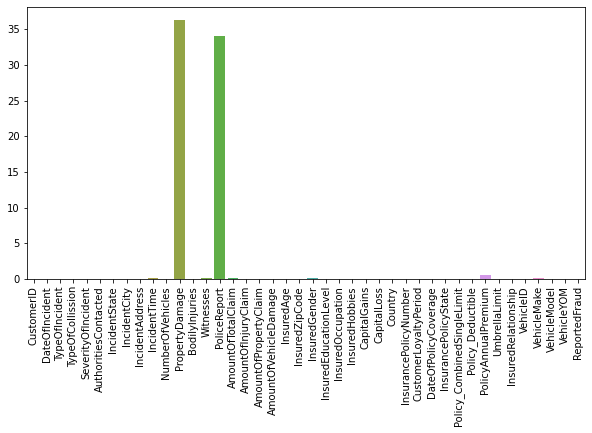

In [24]:
plt.figure(figsize=(10,5))
plot_percentage_null_value(train)

OBSERVATIONS:

We can see that "Property Damage" and "Police Report" attribites has above 30% missing values

In [25]:
#converting necessary data types to date-time format
train['DateOfIncident'] = pd.to_datetime(train['DateOfIncident'])
train['DateOfPolicyCoverage'] = pd.to_datetime(train['DateOfPolicyCoverage'])           

In [26]:
z=train[['DateOfIncident','DateOfPolicyCoverage']]
z['years_as_a_customer']=z['DateOfIncident']-z['DateOfPolicyCoverage']
z['years_as_a_customer']=pd.to_timedelta(z['years_as_a_customer'], errors='coerce').dt.days

In [27]:
train['years_as_a_customer']=z['years_as_a_customer']/365

In [28]:
zz=train['VehicleYOM']
zzz=[]
for i in train['VehicleYOM']:
    zzz.append(2015-i)

In [29]:
train=train.assign(vehicle_age=zzz)

# Differentiating Categorical and Numerical columns

In [30]:
num_cols_for_visualisation=['AmountOfInjuryClaim', 'AmountOfPropertyClaim',
       'AmountOfVehicleDamage','CapitalGains', 'CapitalLoss','Policy_Deductible',
       'PolicyAnnualPremium', 'UmbrellaLimit']

In [31]:
cat_cols_for_visualisation=['TypeOfIncident','SeverityOfIncident', 'AuthoritiesContacted', 'IncidentState',
       'NumberOfVehicles','PropertyDamage', 'BodilyInjuries', 'Witnesses', 'PoliceReport',
       'InsuredGender', 'InsuredEducationLevel','ReportedFraud']

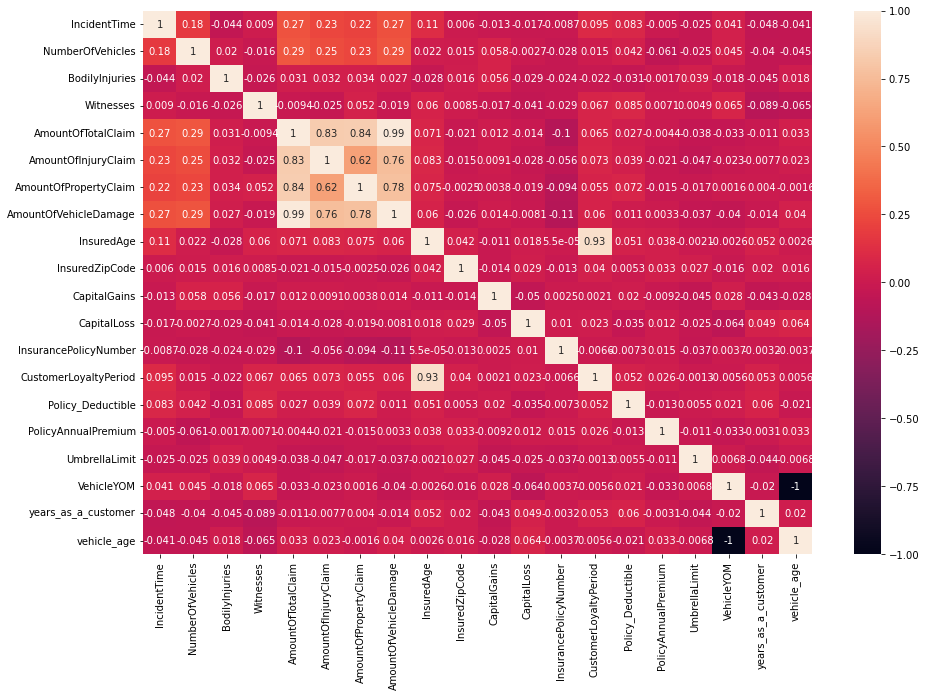

In [32]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(train.corr(), annot=True)

OBSERVATIONS

As 'AmountOfInjuryClaim','AmountOfPropertyClaim','AmountOfVehicleDamage' attributes are highly corelated with 'AmountOfTotalClaim' and 'CustomerLoyaltyPeriod' attribute is corelated with 'InsuredAge', it makes sense to remove the corelated columns.

# Data Visualisation

<Figure size 576x360 with 0 Axes>

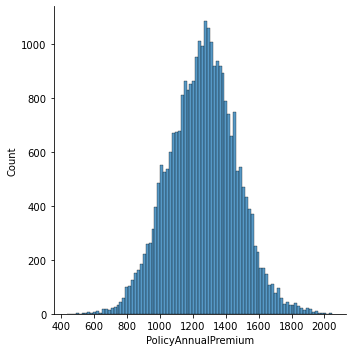

In [33]:
plt.figure(figsize=(8,5))
sns.displot(train['PolicyAnnualPremium'])

OBSERVATIONS

We can see the above distribution is a Normal Distribution, so we can go ahead with mean imputation with "PolicyAnnualPremium" attribute

<AxesSubplot:xlabel='ReportedFraud', ylabel='AmountOfInjuryClaim'>

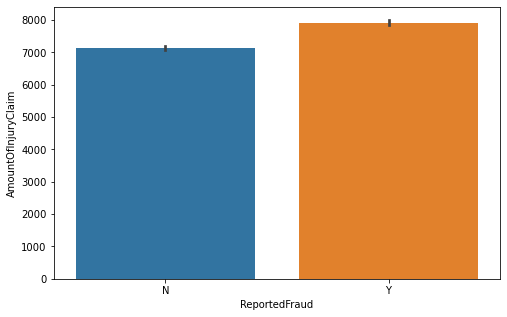

In [34]:
plt.figure(figsize=(8,5))
sns.barplot(x='ReportedFraud', y='AmountOfInjuryClaim', data=train)

OBSERVATIONS

"Amount of injury claim" for fraud claims is high 

<AxesSubplot:xlabel='InsuredAge', ylabel='Count'>

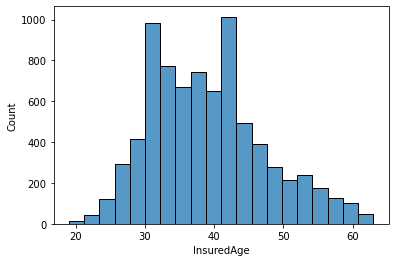

In [35]:
insured_age=train[['CustomerID','InsuredAge','ReportedFraud']]
insured_age=insured_age[insured_age['ReportedFraud']=='Y']
sns.histplot(insured_age['InsuredAge'],bins=20)

OBSERVATIONS

We can see that the people whose age lies between 30 to 45 are more into prone to fraud

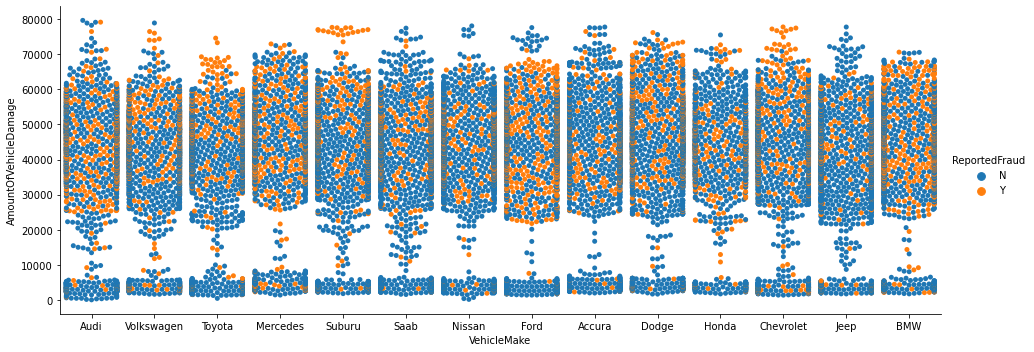

In [36]:
sns.catplot(data=train, x="VehicleMake", y="AmountOfVehicleDamage",hue="ReportedFraud", kind="swarm", aspect=40/15)

OBSERVATIONS

We can see that most people who own Subaru and Chevrolet brand cars have claimed above Rs 70000 in insurance fraudly

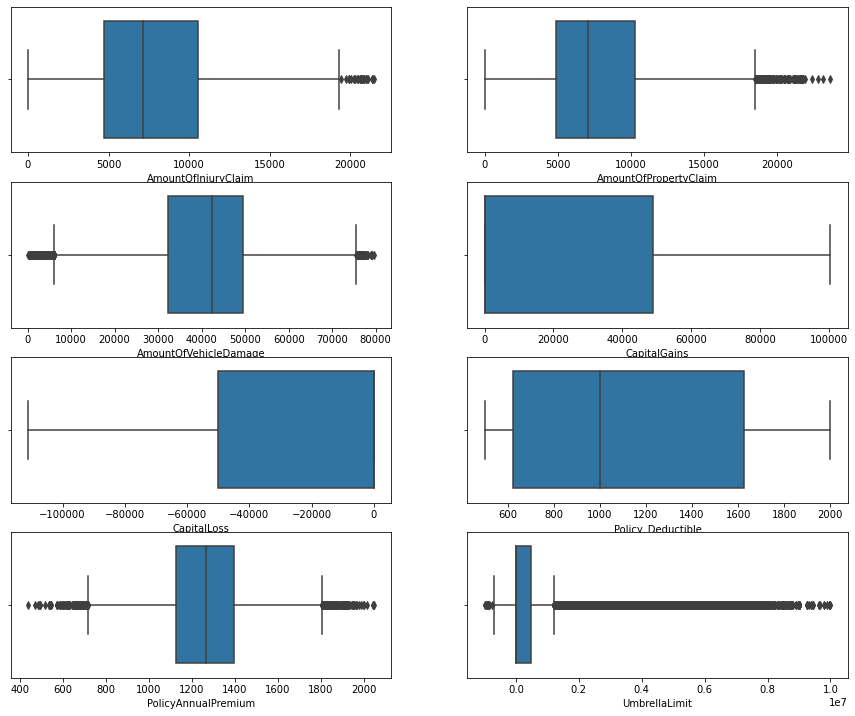

In [37]:
plt.figure(figsize=(15,80))
for i in range(0,len(num_cols_for_visualisation)):
    plt.subplot(25,2,i+1)
    sns.boxplot(x=train[num_cols_for_visualisation[i]], data=train)
    plt.xlabel(num_cols_for_visualisation[i])
    plt.xticks(rotation=0)

OBSERVATIONS

As we can see we have many outliers in the above dataset, outlier treatement is necessary

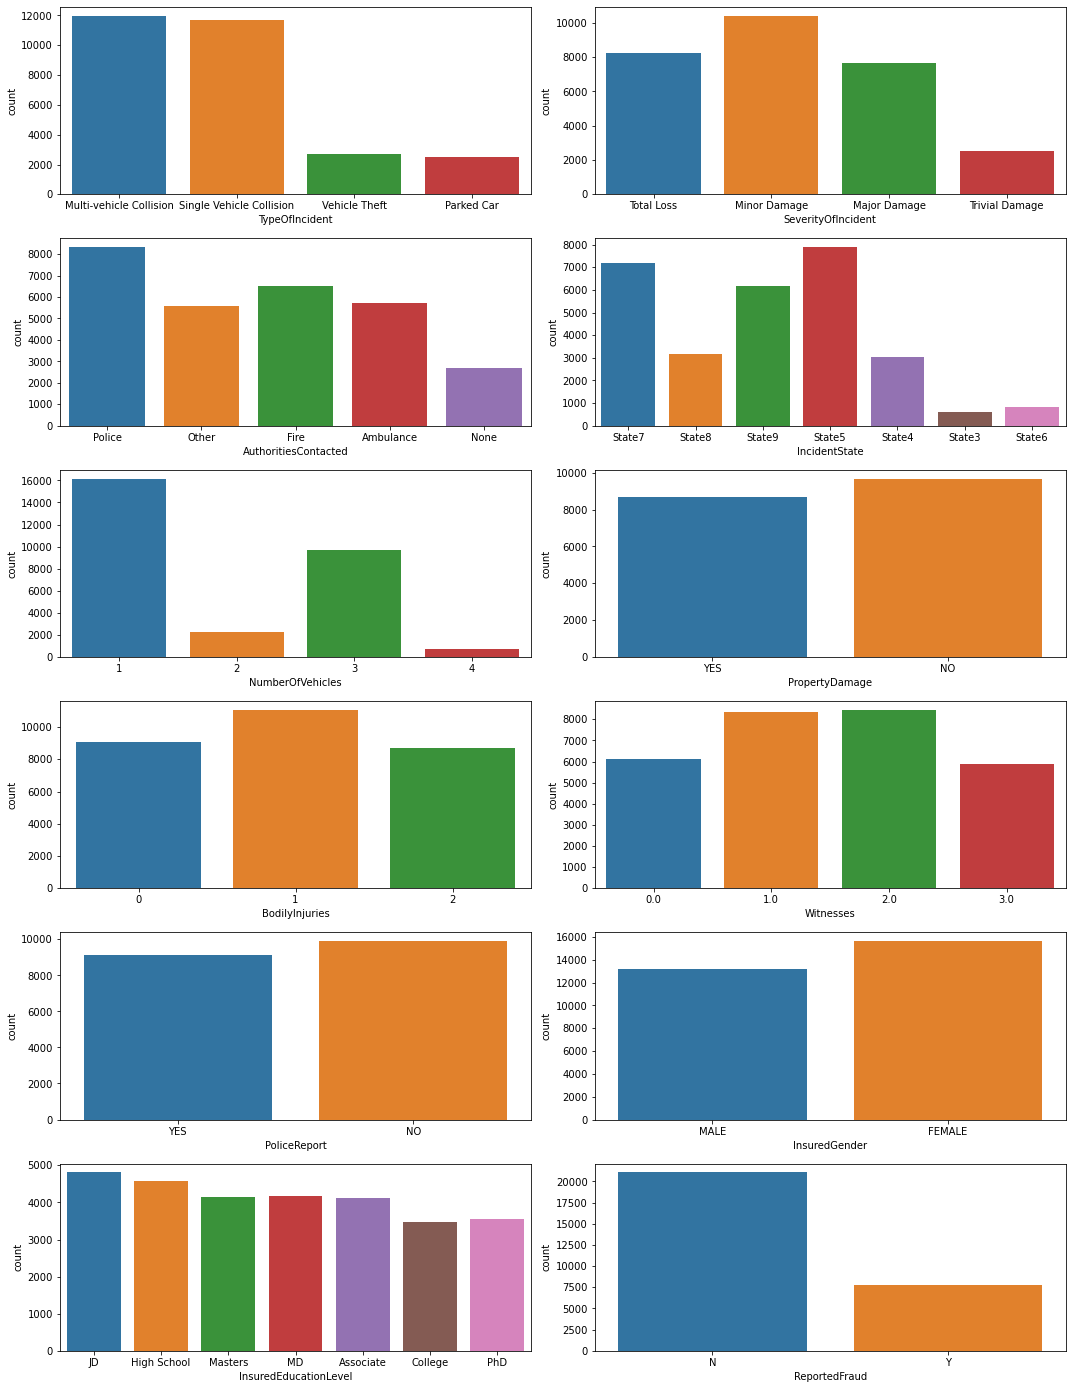

In [38]:
plt.figure(figsize=(15,80))

for i in range(0, len(cat_cols_for_visualisation)):
    plt.subplot(25,2,i+1)
    sns.countplot(x=train[cat_cols_for_visualisation[i]])
    plt.xlabel(cat_cols_for_visualisation[i])
    plt.xticks(rotation=0)
    plt.tight_layout()

OBSERVATIONS

We can infer things like Single and Multi vehicle collision is more as compared to other type of collision from the above Count plot

<AxesSubplot:xlabel='IncidentState', ylabel='count'>

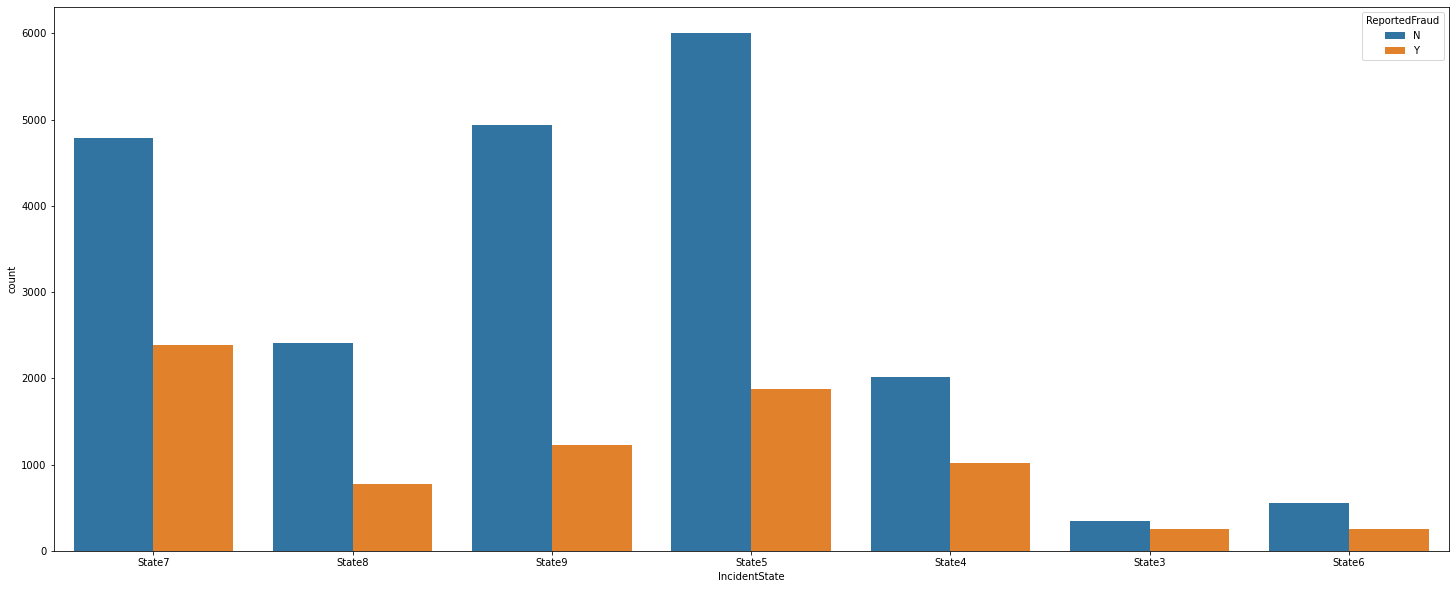

In [39]:
f, ax = plt.subplots(figsize=(25, 10))
sns.countplot(x='IncidentState',hue='ReportedFraud',data=train)

OBSERVATIONS

We can see that "State 7" and "State 5" has more number of fraudulent customers

# As i Plan to use Pipeline for Model building and other Preprocessing steps like Missing value treatement and Scaling. Preprocessing is done in the next phase



# Loading Test data

In [40]:
test_claim=pd.read_csv(r'C:\Users\manoj\Downloads\Capstone_Project_export\capstone-files\TestData\test_data_claim_new1.csv',na_values=['?','Unknown/Invalid','nan','MISSEDDATA','MISSINGVALUE','-5'])
test_demographics=pd.read_csv(r'C:\Users\manoj\Downloads\Capstone_Project_export\capstone-files\TestData\Test_Demographics.csv',na_values=['?','Unknown/Invalid','nan','MISSEDDATA','MISSINGVALUE'])
test_policy=pd.read_csv(r'C:\Users\manoj\Downloads\Capstone_Project_export\capstone-files\TestData\Test_Policy.csv',na_values=['?','Unknown/Invalid','nan','MISSEDDATA','MISSINGVAL','-1'])
test_vehicle=pd.read_csv(r'C:\Users\manoj\Downloads\Capstone_Project_export\capstone-files\TestData\Test_Vehicle.csv',na_values=['?','Unknown/Invalid','nan','MISSEDDATA','MISSINGVALUE','???'])

Loading sample submission file

In [41]:
Otest=pd.read_csv(r'C:\Users\manoj\Downloads\Capstone_Project_export\capstone-files\TestData\test.csv',na_values=['?','Unknown/Invalid','nan','MISSEDDATA','MISSINGVALUE','-5'])

In [42]:
test_claim.head(3)

,Unnamed: 0,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage
0,0,Cust10008,2015-02-05,Multi-vehicle Collision,Front Collision,Minor Damage,Ambulance,State5,City2,Location 1354,4.0,3,NO,0,0.0,NaN,68354.0,6835,8059,53460
1,1,Cust10010,2015-01-13,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State9,City5,Location 1383,16.0,1,NaN,1,1.0,NaN,55270.0,8113,5240,41917
2,2,Cust10015,2015-01-05,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,State5,City2,Location 2030,20.0,3,NO,0,1.0,NaN,59515.0,7490,9110,42915


In [43]:
test_claim=test_claim.iloc[:,1:]

In [44]:
print(test_claim.shape)
print(test_demographics.shape)
print(test_policy.shape)
print(test_vehicle.shape)

(8912, 19)
(8912, 10)
(8912, 10)
(35648, 3)


# Feature Engineering test_vehicle dataset

In [45]:
ttv=test_vehicle.set_index(['CustomerID','VehicleAttribute'], drop=True).unstack('VehicleAttribute')

In [46]:
ttv.columns = ttv.columns.droplevel(0) 
ttv.columns.name = None               
ttv = ttv.reset_index()

In [47]:
ttv.head(2)

,CustomerID,VehicleID,VehicleMake,VehicleModel,VehicleYOM
0,Cust10008,Vehicle34362,Volkswagen,Passat,1995
1,Cust10010,Vehicle17046,Nissan,Ultima,2006


In [48]:
test=pd.merge(test_claim, test_demographics,on='CustomerID',how='outer' )

In [49]:
test=pd.merge(test, test_policy,on='CustomerID',how='outer' )

In [50]:
test=pd.merge(test, ttv,on='CustomerID',how='outer' )

In [51]:
test.shape

(8912, 41)

# Replacing Null values with "Don't know" in "PoliceReport" attribute

In [52]:
test['PoliceReport']=test['PoliceReport'].replace(to_replace = np.nan, value ="Don't know")

In [53]:
#Converting few features to date time format

test['DateOfIncident'] = pd.to_datetime(test['DateOfIncident'])
test['DateOfPolicyCoverage'] = pd.to_datetime(test['DateOfPolicyCoverage'])

# Feature Engineering 

In [54]:
z2=test[['DateOfIncident','DateOfPolicyCoverage']]
z2['years_as_a_customer']=z2['DateOfIncident']-z2['DateOfPolicyCoverage']
z2['years_as_a_customer']=pd.to_timedelta(z2['years_as_a_customer'], errors='coerce').dt.days

In [55]:
test['VehicleYOM']=test['VehicleYOM'].astype(int)

In [56]:
test['years_as_a_customer']=z2['years_as_a_customer']/365

# Feature Engineering for "VehicleYOM" attribute

In [57]:
zz=test['VehicleYOM']
zzz2=[]
for i in test['VehicleYOM']:
    zzz2.append(2015-i)

In [58]:
test=test.assign(vehicle_age=zzz2)

In [59]:
test2=test.copy()

In [60]:
test.head(3)

,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,...,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,years_as_a_customer,vehicle_age
0,Cust10008,2015-02-05,Multi-vehicle Collision,Front Collision,Minor Damage,Ambulance,State5,City2,Location 1354,4.0,...,2000,1006.00,0,own-child,Vehicle34362,Volkswagen,Passat,1995,16.753425,20
1,Cust10010,2015-01-13,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State9,City5,Location 1383,16.0,...,500,1279.17,0,unmarried,Vehicle17046,Nissan,Ultima,2006,3.178082,9
2,Cust10015,2015-01-05,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,State5,City2,Location 2030,20.0,...,1000,1454.67,1235986,other-relative,Vehicle11038,Suburu,Impreza,2010,4.473973,5


In [61]:
train['ReportedFraud'].value_counts()

N    21051
Y     7785
Name: ReportedFraud, dtype: int64

# OBSERVATION:

We can see that the dataset is highly imbalanced, with only 0.33% of transactions being classified as fraudulent.

# Dealing with Imbalanced Data - Oversampling minority class,Undersample majority class and SMOTE Techniques

In [62]:
from sklearn.utils import resample
#from imblearn import under_sampling 
#from imblearn import over_sampling
#from imblearn.over_sampling import SMOTE

In [63]:
b = train['ReportedFraud']
a = train.drop(['ReportedFraud'],axis=1)

In [64]:
b.replace(['Y','N'],[1,0],inplace=True)

In [65]:
a_train, a_test, b_train, b_test = train_test_split(a, b, test_size=0.25, random_state=27)

In [66]:
a = pd.concat([a_train, b_train], axis=1)

In [67]:
not_fraud = a[a['ReportedFraud']==0]
fraud = a[a['ReportedFraud']==1]

In [68]:
#Upsampling
fraud_upsampled = resample(fraud,
                          replace=True,             # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27)          # reproducible results


In [69]:
#Downsampling
not_fraud_downsampled = resample(not_fraud,
                                replace = False, 
                                n_samples = len(fraud),
                                random_state = 27) 

In [70]:
upsampled = pd.concat([not_fraud, fraud_upsampled])

downsampled = pd.concat([not_fraud_downsampled, fraud])

In [71]:
upsampled.ReportedFraud.value_counts()

0    15782
1    15782
Name: ReportedFraud, dtype: int64

In [72]:
downsampled.ReportedFraud.value_counts()

0    5845
1    5845
Name: ReportedFraud, dtype: int64

In [73]:
b_train = upsampled.ReportedFraud
a_train = upsampled.drop('ReportedFraud', axis=1)

d_train = downsampled.ReportedFraud
c_train = downsampled.drop('ReportedFraud', axis=1)

In [74]:
a=a_train
b=b_train

c=c_train
d=d_train

# Droping unwanted Columns in Train and Test data

In [75]:
train.drop(['CustomerID','IncidentAddress','DateOfIncident','InsuredZipCode','PropertyDamage','CustomerLoyaltyPeriod','Country','InsurancePolicyNumber','InsuredEducationLevel','InsuredRelationship','VehicleID','AmountOfTotalClaim','VehicleYOM'],axis=1,inplace=True)

In [76]:
test.drop(['CustomerID','IncidentAddress','DateOfIncident','InsuredZipCode','PropertyDamage','CustomerLoyaltyPeriod','Country','InsurancePolicyNumber','InsuredEducationLevel','InsuredRelationship','VehicleID','AmountOfTotalClaim','VehicleYOM'],axis=1,inplace=True)

# Model Building

In [77]:
y=train['ReportedFraud']
X=train.drop(['ReportedFraud'],axis=1)

In [78]:
y.replace(['Y','N'],[1,0],inplace=True)

# Categorising Categorical and Numerical attributes

In [79]:
num_cols=['AmountOfInjuryClaim', 'AmountOfPropertyClaim','years_as_a_customer',
       'AmountOfVehicleDamage','CapitalGains', 'CapitalLoss','Policy_Deductible',
       'PolicyAnnualPremium', 'UmbrellaLimit','vehicle_age']

In [80]:
cat_cols=['TypeOfIncident', 'TypeOfCollission','SeverityOfIncident', 'AuthoritiesContacted', 'IncidentState',
       'IncidentCity','NumberOfVehicles', 'BodilyInjuries', 'Witnesses', 'PoliceReport',
       'InsuredGender','InsuredOccupation','InsuredHobbies','VehicleMake', 'VehicleModel']

<AxesSubplot:xlabel='PoliceReport', ylabel='count'>

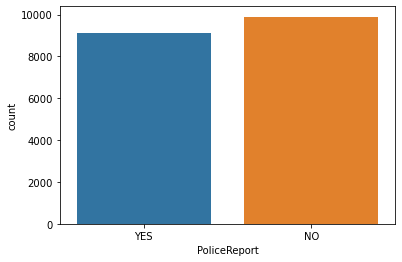

In [81]:
sns.countplot(x='PoliceReport',data=train)

In [82]:
train['PoliceReport']=train['PoliceReport'].replace(to_replace = np.nan, value ="Don't know")

# Train test Split

In [83]:
#Upsampling
X_train, X_test, y_train, y_test = train_test_split(a,b,test_size=0.25,random_state=0)

#Downsampling
#X_train, X_test, y_train, y_test = train_test_split(c,d,test_size=0.25,random_state=0)

In [84]:
X[cat_cols] = X[cat_cols].astype('category')

# Pre-Processing and Model fitting using Pipeline

In [85]:
Numeric_transformer=Pipeline([('Missing values', SimpleImputer(strategy='mean'))
                              ,('scalar1',StandardScaler())])

In [86]:
categorical_transformer=Pipeline([('Missing values',SimpleImputer(strategy='most_frequent'))
                              ,('ohe',OneHotEncoder(handle_unknown='ignore'))])

In [87]:
preprocessor=(ColumnTransformer(transformers=[('num',Numeric_transformer,num_cols),('cat',categorical_transformer,cat_cols)]))

In [88]:
RF_pipe = Pipeline([('pp',preprocessor),('RF',RandomForestClassifier())])

In [89]:
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Missing '
                                                                   'values',
                                                                   SimpleImputer()),
                                                                  ('scalar1',
                                                                   StandardScaler())]),
                                                  ['AmountOfInjuryClaim',
                                                   'AmountOfPropertyClaim',
                                                   'years_as_a_customer',
                                                   'AmountOfVehicleDamage',
                                                   'CapitalGains',
                                                   'CapitalLoss',
                                                   'Policy_Deductible',
                                                   'PolicyAnnualPremium',
                                                   'UmbrellaLimit',
                                                   'vehicle_age']),
                                                 ('cat',
                                                  Pip...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TypeOfIncident',
                                                   'TypeOfCollission',
                                                   'SeverityOfIncident',
                                                   'AuthoritiesContacted',
                                                   'IncidentState',
                                                   'IncidentCity',
                                                   'NumberOfVehicles',
                                                   'BodilyInjuries',
                                                   'Witnesses', 'PoliceReport',
                                                   'InsuredGender',
                                                   'InsuredOccupation',
                                                   'InsuredHobbies',
                                                   'VehicleMake',
                                                   'VehicleModel'])])),
                ('RF', RandomForestClassifier())])

# Predicting model accuracy for test data from train-test split

In [90]:
train_pred_RFPipe = RF_pipe.predict(X_train)
test_pred_RFPipe = RF_pipe.predict(X_test)

In [91]:
# to print evaluation/confusion matrix
def evaluate_model(act, pred):
    from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
    print("Confusion Matrix \n", confusion_matrix(act, pred))
    print("Accurcay : ", accuracy_score(act, pred))
    print("Recall   : ", recall_score(act, pred,average='weighted'))
    print("Precision: ", precision_score(act, pred, average='weighted'))

In [92]:
print("--Train--")
evaluate_model(y_train, train_pred_RFPipe)
print("--Test--")
evaluate_model(y_test, test_pred_RFPipe)

--Train--
Confusion Matrix 
 [[11909     0]
 [    0 11764]]
Accurcay :  1.0
Recall   :  1.0
Precision:  1.0
--Test--
Confusion Matrix 
 [[3711  162]
 [ 113 3905]]
Accurcay :  0.9651501710809783
Recall   :  0.9651501710809783
Precision:  0.9652140219209061


In [93]:
from sklearn.metrics import f1_score

In [94]:
f1_score(y_test,test_pred_RFPipe, pos_label=1)

0.9659863945578232

# Prediction using Original Test data 

In [95]:
test_pred_ORFPipe = RF_pipe.predict(test)

In [96]:
test_pred_ORFPipe.shape

(8912,)

In [97]:
test2['Prediction']=test_pred_ORFPipe

In [98]:
test3=test2[['CustomerID','Prediction']]

In [99]:
test3.head(3)

,CustomerID,Prediction
0,Cust10008,0
1,Cust10010,0
2,Cust10015,0


In [100]:
Otest=Otest.merge(test3,on='CustomerID')

In [101]:
print(Otest['Prediction'].value_counts())

0    7441
1    1471
Name: Prediction, dtype: int64


In [102]:
#Otest.to_csv('sample_sub.csv')

In [103]:
colz=RF_pipe[:-1].get_feature_names_out()
print(colz)

['num__AmountOfInjuryClaim' 'num__AmountOfPropertyClaim'
 'num__years_as_a_customer' 'num__AmountOfVehicleDamage'
 'num__CapitalGains' 'num__CapitalLoss' 'num__Policy_Deductible'
 'num__PolicyAnnualPremium' 'num__UmbrellaLimit' 'num__vehicle_age'
 'cat__TypeOfIncident_Multi-vehicle Collision'
 'cat__TypeOfIncident_Parked Car'
 'cat__TypeOfIncident_Single Vehicle Collision'
 'cat__TypeOfIncident_Vehicle Theft'
 'cat__TypeOfCollission_Front Collision'
 'cat__TypeOfCollission_Rear Collision'
 'cat__TypeOfCollission_Side Collision'
 'cat__SeverityOfIncident_Major Damage'
 'cat__SeverityOfIncident_Minor Damage'
 'cat__SeverityOfIncident_Total Loss'
 'cat__SeverityOfIncident_Trivial Damage'
 'cat__AuthoritiesContacted_Ambulance' 'cat__AuthoritiesContacted_Fire'
 'cat__AuthoritiesContacted_None' 'cat__AuthoritiesContacted_Other'
 'cat__AuthoritiesContacted_Police' 'cat__IncidentState_State3'
 'cat__IncidentState_State4' 'cat__IncidentState_State5'
 'cat__IncidentState_State6' 'cat__IncidentSt

# Top 20 feature extraction from Randomforest algorithm

In [104]:
std = np.std([RF_pipe.get_params()['RF'].feature_importances_ for tree in RF_pipe.get_params()['RF'].estimators_], axis=0)

In [105]:
feature_importances = RF_pipe.get_params()['RF'].feature_importances_

In [106]:
feature_names=[f"feature {i}" for i in range(X.shape[1])]

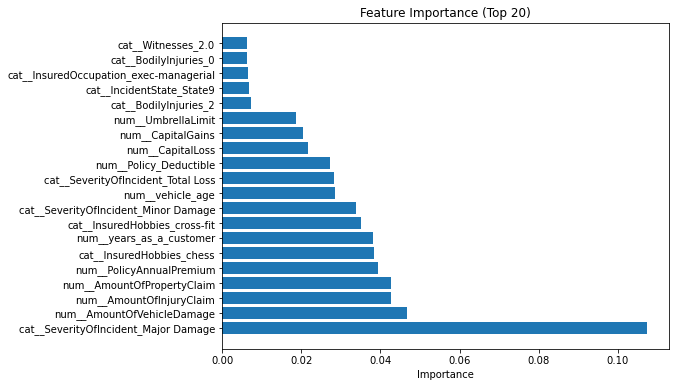

In [107]:
# Calculate feature importance using random forest model
feature_importance = pd.Series(RF_pipe.get_params()['RF'].feature_importances_, index=colz)

# Get the top 20 features with highest importance and plot them
top_20 = feature_importance.nlargest(20)
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top_20.index, top_20.values)
ax.set_xlabel('Importance')
ax.set_title('Feature Importance (Top 20)')

# Show the plot
plt.show()

# ADABOOST Classifier

In [108]:
from sklearn.ensemble import AdaBoostClassifier

In [109]:
RF_pipe_ada = Pipeline([('pp',preprocessor),('ada',AdaBoostClassifier())])

In [110]:
RF_pipe_ada.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Missing '
                                                                   'values',
                                                                   SimpleImputer()),
                                                                  ('scalar1',
                                                                   StandardScaler())]),
                                                  ['AmountOfInjuryClaim',
                                                   'AmountOfPropertyClaim',
                                                   'years_as_a_customer',
                                                   'AmountOfVehicleDamage',
                                                   'CapitalGains',
                                                   'CapitalLoss',
                                                   'Policy_Deductible',
                                                   'PolicyAnnualPremium',
                                                   'UmbrellaLimit',
                                                   'vehicle_age']),
                                                 ('cat',
                                                  Pip...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TypeOfIncident',
                                                   'TypeOfCollission',
                                                   'SeverityOfIncident',
                                                   'AuthoritiesContacted',
                                                   'IncidentState',
                                                   'IncidentCity',
                                                   'NumberOfVehicles',
                                                   'BodilyInjuries',
                                                   'Witnesses', 'PoliceReport',
                                                   'InsuredGender',
                                                   'InsuredOccupation',
                                                   'InsuredHobbies',
                                                   'VehicleMake',
                                                   'VehicleModel'])])),
                ('ada', AdaBoostClassifier())])

In [111]:
train_pred_RFPipe_ada = RF_pipe_ada.predict(X_train)
test_pred_RFPipe_ada = RF_pipe_ada.predict(X_test)

In [112]:
print("--Train--")
evaluate_model(y_train, train_pred_RFPipe_ada)
print("--Test--")
evaluate_model(y_test, test_pred_RFPipe_ada)

--Train--
Confusion Matrix 
 [[9920 1989]
 [2652 9112]]
Accurcay :  0.8039538714991763
Recall   :  0.8039538714991763
Precision:  0.8048436943373337
--Test--
Confusion Matrix 
 [[3215  658]
 [ 918 3100]]
Accurcay :  0.8002787986313522
Recall   :  0.8002787986313522
Precision:  0.8018281084179153


In [113]:
f1_score(y_test,test_pred_RFPipe_ada)

0.7973251028806584

# Hyper Parameter tuning for Random forest

In [114]:
from sklearn.model_selection import GridSearchCV

param_grid={"ada__n_estimators":[60,100,140],
            "ada__learning_rate":[1,3]}

grid_search=GridSearchCV(RF_pipe_ada,param_grid,cv=10)

In [115]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('Missing '
                                                                                          'values',
                                                                                          SimpleImputer()),
                                                                                         ('scalar1',
                                                                                          StandardScaler())]),
                                                                         ['AmountOfInjuryClaim',
                                                                          'AmountOfPropertyClaim',
                                                                          'years_as_a_customer',
                                                                          'AmountOfVehicleDamage',
                                                                          'CapitalGains',
                                                                          'CapitalLoss',
                                                                          'Policy_Deductible',
                                                                          'PolicyAnnualPremium',
                                                                          'UmbrellaLimi...
                                                                         ['TypeOfIncident',
                                                                          'TypeOfCollission',
                                                                          'SeverityOfIncident',
                                                                          'AuthoritiesContacted',
                                                                          'IncidentState',
                                                                          'IncidentCity',
                                                                          'NumberOfVehicles',
                                                                          'BodilyInjuries',
                                                                          'Witnesses',
                                                                          'PoliceReport',
                                                                          'InsuredGender',
                                                                          'InsuredOccupation',
                                                                          'InsuredHobbies',
                                                                          'VehicleMake',
                                                                          'VehicleModel'])])),
                                       ('ada', AdaBoostClassifier())]),
             param_grid={'ada__learning_rate': [1, 3],
                         'ada__n_estimators': [60, 100, 140]})

In [116]:
print("best_params:")
print(grid_search.best_params_)

best_params:
{'ada__learning_rate': 1, 'ada__n_estimators': 140}


In [117]:
gs=grid_search.predict(X_test)

In [118]:
train_RFPipe_gs = grid_search.predict(X_train)
test_RFPipe_gs = grid_search.predict(X_test)

In [119]:
print("--Train--")
evaluate_model(y_train, train_RFPipe_gs)
print("--Test--")
evaluate_model(y_test, test_RFPipe_gs)

--Train--
Confusion Matrix 
 [[9957 1952]
 [2528 9236]]
Accurcay :  0.8107548684154945
Recall   :  0.8107548684154945
Precision:  0.8114364022412729
--Test--
Confusion Matrix 
 [[3204  669]
 [ 860 3158]]
Accurcay :  0.8062349512102395
Recall   :  0.8062349512102395
Precision:  0.8071257750324946


In [120]:
f1_score(y_test,gs, pos_label=1)

0.8050987890376036

# Applying other Algorithms

# Applying logistic Regression

In [121]:
RF_pipe1 = Pipeline([('pp',preprocessor),('LR',LogisticRegression())])

In [122]:
RF_pipe1.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Missing '
                                                                   'values',
                                                                   SimpleImputer()),
                                                                  ('scalar1',
                                                                   StandardScaler())]),
                                                  ['AmountOfInjuryClaim',
                                                   'AmountOfPropertyClaim',
                                                   'years_as_a_customer',
                                                   'AmountOfVehicleDamage',
                                                   'CapitalGains',
                                                   'CapitalLoss',
                                                   'Policy_Deductible',
                                                   'PolicyAnnualPremium',
                                                   'UmbrellaLimit',
                                                   'vehicle_age']),
                                                 ('cat',
                                                  Pip...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TypeOfIncident',
                                                   'TypeOfCollission',
                                                   'SeverityOfIncident',
                                                   'AuthoritiesContacted',
                                                   'IncidentState',
                                                   'IncidentCity',
                                                   'NumberOfVehicles',
                                                   'BodilyInjuries',
                                                   'Witnesses', 'PoliceReport',
                                                   'InsuredGender',
                                                   'InsuredOccupation',
                                                   'InsuredHobbies',
                                                   'VehicleMake',
                                                   'VehicleModel'])])),
                ('LR', LogisticRegression())])

In [123]:
train_pred_RFPipe1 = RF_pipe1.predict(X_train)
test_pred_RFPipe1 = RF_pipe1.predict(X_test)

In [124]:
print("--Train--")
evaluate_model(y_train, train_pred_RFPipe1)
print("--Test--")
evaluate_model(y_test, test_pred_RFPipe1)

--Train--
Confusion Matrix 
 [[9958 1951]
 [2711 9053]]
Accurcay :  0.8030667849448739
Recall   :  0.8030667849448739
Precision:  0.8042446110437929
--Test--
Confusion Matrix 
 [[3198  675]
 [ 943 3075]]
Accurcay :  0.7949562793055379
Recall   :  0.7949562793055379
Precision:  0.7965770755253195


In [125]:
f1_score(y_test,test_pred_RFPipe1)

0.7917095777548919

# Applying SVM

In [126]:
  from sklearn import svm
SVC=svm.SVC()
RF_pipe2 = Pipeline([('pp',preprocessor),('SVC',SVC)])

In [127]:
RF_pipe2.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Missing '
                                                                   'values',
                                                                   SimpleImputer()),
                                                                  ('scalar1',
                                                                   StandardScaler())]),
                                                  ['AmountOfInjuryClaim',
                                                   'AmountOfPropertyClaim',
                                                   'years_as_a_customer',
                                                   'AmountOfVehicleDamage',
                                                   'CapitalGains',
                                                   'CapitalLoss',
                                                   'Policy_Deductible',
                                                   'PolicyAnnualPremium',
                                                   'UmbrellaLimit',
                                                   'vehicle_age']),
                                                 ('cat',
                                                  Pip...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TypeOfIncident',
                                                   'TypeOfCollission',
                                                   'SeverityOfIncident',
                                                   'AuthoritiesContacted',
                                                   'IncidentState',
                                                   'IncidentCity',
                                                   'NumberOfVehicles',
                                                   'BodilyInjuries',
                                                   'Witnesses', 'PoliceReport',
                                                   'InsuredGender',
                                                   'InsuredOccupation',
                                                   'InsuredHobbies',
                                                   'VehicleMake',
                                                   'VehicleModel'])])),
                ('SVC', SVC())])

In [128]:
train_pred_RFPipe2 = RF_pipe2.predict(X_train)
test_pred_RFPipe2 = RF_pipe2.predict(X_test)

In [129]:
print("--Train--")
evaluate_model(y_train, train_pred_RFPipe2)
print("--Test--")
evaluate_model(y_test, test_pred_RFPipe2)

--Train--
Confusion Matrix 
 [[11610   299]
 [ 1265 10499]]
Accurcay :  0.9339331728129092
Recall   :  0.9339331728129092
Precision:  0.9368125291379197
--Test--
Confusion Matrix 
 [[3713  160]
 [ 529 3489]]
Accurcay :  0.9126853377265239
Recall   :  0.9126853377265239
Precision:  0.9164664162503368


In [130]:
f1_score(y_test,test_pred_RFPipe2)

0.9101343419851312

# Hyperparameter tuning for SVC

In [131]:
param_grid1 = {'SVC__C': [1, 10],'SVC__kernel': ['rbf', 'poly', 'sigmoid']}

In [132]:
from sklearn.model_selection import GridSearchCV


In [133]:
grid_svc = GridSearchCV(RF_pipe2,param_grid1,refit=True,verbose=2)
grid_svc.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..........................SVC__C=1, SVC__kernel=rbf; total time= 3.0min
[CV] END ..........................SVC__C=1, SVC__kernel=rbf; total time= 2.2min
[CV] END ..........................SVC__C=1, SVC__kernel=rbf; total time= 2.2min
[CV] END ..........................SVC__C=1, SVC__kernel=rbf; total time= 2.2min
[CV] END ..........................SVC__C=1, SVC__kernel=rbf; total time= 2.2min
[CV] END .........................SVC__C=1, SVC__kernel=poly; total time= 5.3min
[CV] END .........................SVC__C=1, SVC__kernel=poly; total time= 2.4min
[CV] END .........................SVC__C=1, SVC__kernel=poly; total time= 2.5min
[CV] END .........................SVC__C=1, SVC__kernel=poly; total time= 2.5min
[CV] END .........................SVC__C=1, SVC__kernel=poly; total time= 2.6min
[CV] END ......................SVC__C=1, SVC__kernel=sigmoid; total time= 1.4min
[CV] END ......................SVC__C=1, SVC__ker

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('Missing '
                                                                                          'values',
                                                                                          SimpleImputer()),
                                                                                         ('scalar1',
                                                                                          StandardScaler())]),
                                                                         ['AmountOfInjuryClaim',
                                                                          'AmountOfPropertyClaim',
                                                                          'years_as_a_customer',
                                                                          'AmountOfVehicleDamage',
                                                                          'CapitalGains',
                                                                          'CapitalLoss',
                                                                          'Policy_Deductible',
                                                                          'PolicyAnnualPremium',
                                                                          'UmbrellaLimit',
                                                                          've...
                                                                         ['TypeOfIncident',
                                                                          'TypeOfCollission',
                                                                          'SeverityOfIncident',
                                                                          'AuthoritiesContacted',
                                                                          'IncidentState',
                                                                          'IncidentCity',
                                                                          'NumberOfVehicles',
                                                                          'BodilyInjuries',
                                                                          'Witnesses',
                                                                          'PoliceReport',
                                                                          'InsuredGender',
                                                                          'InsuredOccupation',
                                                                          'InsuredHobbies',
                                                                          'VehicleMake',
                                                                          'VehicleModel'])])),
                                       ('SVC', SVC())]),
             param_grid={'SVC__C': [1, 10],
                         'SVC__kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [134]:
grid_predictions = grid_svc.predict(X_test)

In [135]:
train_pred_RFPipesvc = grid_svc.predict(X_train)
test_pred_RFPipesvc = grid_svc.predict(X_test)

In [136]:
print("--Train--")
evaluate_model(y_train, train_pred_RFPipesvc)
print("--Test--")
evaluate_model(y_test, test_pred_RFPipesvc)

--Train--
Confusion Matrix 
 [[11848    61]
 [   88 11676]]
Accurcay :  0.9937059096861404
Recall   :  0.9937059096861404
Precision:  0.9937083908332583
--Test--
Confusion Matrix 
 [[3672  201]
 [ 165 3853]]
Accurcay :  0.9536180458750475
Recall   :  0.9536180458750475
Precision:  0.9536480571990555


In [137]:
f1_score(y_test,grid_predictions)

0.9546580773042618

In [138]:
svc_pred=grid_svc.predict(test)

In [139]:
svc_pred.shape

(8912,)

In [140]:
test2['Prediction1']=svc_pred

In [141]:
test3=test2[['CustomerID','Prediction1']]

In [142]:
Otest=Otest.merge(test3,on='CustomerID')

In [143]:
print(Otest['Prediction1'].value_counts())

0    7298
1    1614
Name: Prediction1, dtype: int64


In [144]:
Otest1=Otest[['CustomerID','Prediction1']]

In [145]:
Otest1

,CustomerID,Prediction1
0,Cust10008,0
1,Cust10010,0
2,Cust10015,0
3,Cust10020,0
4,Cust1003,0
...,...,...
8907,Cust37942,0
8908,Cust20528,0
8909,Cust36797,0
8910,Cust28499,0


In [146]:
#Otest1.to_csv('sample_sub1.csv')

# Applying KKN

In [147]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()

In [148]:
RF_pipe3 = Pipeline([('pp',preprocessor),('KNN',KNN)])

In [149]:
RF_pipe3.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Missing '
                                                                   'values',
                                                                   SimpleImputer()),
                                                                  ('scalar1',
                                                                   StandardScaler())]),
                                                  ['AmountOfInjuryClaim',
                                                   'AmountOfPropertyClaim',
                                                   'years_as_a_customer',
                                                   'AmountOfVehicleDamage',
                                                   'CapitalGains',
                                                   'CapitalLoss',
                                                   'Policy_Deductible',
                                                   'PolicyAnnualPremium',
                                                   'UmbrellaLimit',
                                                   'vehicle_age']),
                                                 ('cat',
                                                  Pip...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TypeOfIncident',
                                                   'TypeOfCollission',
                                                   'SeverityOfIncident',
                                                   'AuthoritiesContacted',
                                                   'IncidentState',
                                                   'IncidentCity',
                                                   'NumberOfVehicles',
                                                   'BodilyInjuries',
                                                   'Witnesses', 'PoliceReport',
                                                   'InsuredGender',
                                                   'InsuredOccupation',
                                                   'InsuredHobbies',
                                                   'VehicleMake',
                                                   'VehicleModel'])])),
                ('KNN', KNeighborsClassifier())])

In [150]:
train_pred_RFPipe3 = RF_pipe3.predict(X_train)
test_pred_RFPipe3 = RF_pipe3.predict(X_test)

In [151]:
print("--Train--")
evaluate_model(y_train, train_pred_RFPipe3)
print("--Test--")
evaluate_model(y_test, test_pred_RFPipe3)

--Train--
Confusion Matrix 
 [[11086   823]
 [  630 11134]]
Accurcay :  0.9386220588856503
Recall   :  0.9386220588856503
Precision:  0.9387448177078734
--Test--
Confusion Matrix 
 [[3468  405]
 [ 381 3637]]
Accurcay :  0.9003928526169054
Recall   :  0.9003928526169054
Precision:  0.9003965363234543


In [152]:
f1_score(y_test,test_pred_RFPipe3)

0.9024813895781637

# Hyperparameter tuning for KNN

In [153]:
param_grid = { 'KNN__n_neighbors' : [5,7,9],
               'KNN__weights' : ['uniform','distance'],
               'KNN__metric' : ['minkowski','euclidean','manhattan']}

In [154]:
grid_search1=GridSearchCV(RF_pipe3,param_grid,cv=10)

In [155]:
grid_search1.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('Missing '
                                                                                          'values',
                                                                                          SimpleImputer()),
                                                                                         ('scalar1',
                                                                                          StandardScaler())]),
                                                                         ['AmountOfInjuryClaim',
                                                                          'AmountOfPropertyClaim',
                                                                          'years_as_a_customer',
                                                                          'AmountOfVehicleDamage',
                                                                          'CapitalGains',
                                                                          'CapitalLoss',
                                                                          'Policy_Deductible',
                                                                          'PolicyAnnualPremium',
                                                                          'UmbrellaLimi...
                                                                          'AuthoritiesContacted',
                                                                          'IncidentState',
                                                                          'IncidentCity',
                                                                          'NumberOfVehicles',
                                                                          'BodilyInjuries',
                                                                          'Witnesses',
                                                                          'PoliceReport',
                                                                          'InsuredGender',
                                                                          'InsuredOccupation',
                                                                          'InsuredHobbies',
                                                                          'VehicleMake',
                                                                          'VehicleModel'])])),
                                       ('KNN', KNeighborsClassifier())]),
             param_grid={'KNN__metric': ['minkowski', 'euclidean', 'manhattan'],
                         'KNN__n_neighbors': [5, 7, 9],
                         'KNN__weights': ['uniform', 'distance']})

In [156]:
grid_predictions = grid_search1.predict(X_test)

In [157]:
train_pred_RFPipeknn = grid_search1.predict(X_train)
test_pred_RFPipeknn = grid_search1.predict(X_test)

In [158]:
print("--Train--")
evaluate_model(y_train, train_pred_RFPipeknn)
print("--Test--")
evaluate_model(y_test, test_pred_RFPipeknn)

--Train--
Confusion Matrix 
 [[11909     0]
 [    0 11764]]
Accurcay :  1.0
Recall   :  1.0
Precision:  1.0
--Test--
Confusion Matrix 
 [[3609  264]
 [  97 3921]]
Accurcay :  0.9542516791281206
Recall   :  0.9542516791281206
Precision:  0.9550327901479495


In [159]:
f1_score(y_test,grid_predictions, pos_label=1)

0.955991710349872

In [160]:
knn_pred=grid_search.predict(test)

In [161]:
test2['Prediction2']=knn_pred

In [162]:
test4=test2[['CustomerID','Prediction2']]

In [163]:
test4.head(3)

,CustomerID,Prediction2
0,Cust10008,0
1,Cust10010,0
2,Cust10015,0


In [164]:
Otest=Otest.merge(test4,on='CustomerID')

In [165]:
Otest2=Otest[['CustomerID','Prediction2']]

In [166]:
Otest2.head(3)

,CustomerID,Prediction2
0,Cust10008,0
1,Cust10010,0
2,Cust10015,0


In [167]:
print(Otest2['Prediction2'].value_counts())

0    6577
1    2335
Name: Prediction2, dtype: int64


In [168]:
#Otest2.to_csv('sample_sub3.csv')